# Self-Driving Car Engineer Nanodegree
## Project: Vehicle Detection and Tracking

In [1]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
import os
import time
import pickle
from moviepy.editor import VideoFileClip
from skimage.feature import hog
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline

from sklearn.model_selection import train_test_split
from scipy.ndimage.measurements import label
from tqdm import tqdm


from sklearn.externals import joblib
from skimage.feature import hog
# Specific Required functions bundled in functions_required.py file (as part of the project)
from functions_required import *
%matplotlib inline
#from skimage.feature import hog
#from skimage import color, exposure
# images are divided up into vehicles and non-vehicles

/home/hari/anaconda3/lib/python3.6/site-packages/skimage/filter/__init__.py:6: skimage_deprecation: The `skimage.filter` module has been renamed to `skimage.filters`.  This placeholder module will be removed in v0.13.
  warn(skimage_deprecation('The `skimage.filter` module has been renamed '


In [2]:
# Read in cars and notcars
images = glob.glob('*vehicles/*/*')
cars = []
notcars = []
for image in images:
    if 'non' in image:
        notcars.append(image)
    else:
        cars.append(image)
## Uncomment if you need to reduce the sample size
#sample_size = 500
#cars = cars[0:sample_size]
#notcars = notcars[0:sample_size]
print(len(cars))
print(len(notcars))

8792
8968


Your function returned a count of 8792  cars and 8968  non-cars
of size:  (64, 64, 3)  and data type: float32


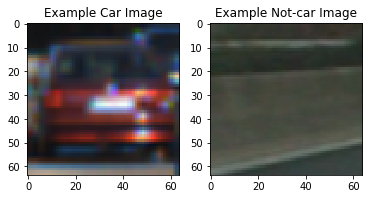

In [3]:
# Define a function to return some characteristics of the dataset 
def data_look(car_list, notcar_list):
    data_dict = {}
    # Define a key in data_dict "n_cars" and store the number of car images
    data_dict["n_cars"] = len(car_list)
    # Define a key "n_notcars" and store the number of notcar images
    data_dict["n_notcars"] = len(notcar_list)
    # Read in a test image, either car or notcar
    example_img = mpimg.imread(car_list[0])
    # Define a key "image_shape" and store the test image shape 3-tuple
    data_dict["image_shape"] = example_img.shape
    # Define a key "data_type" and store the data type of the test image.
    data_dict["data_type"] = example_img.dtype
    # Return data_dict
    return data_dict
    
data_info = data_look(cars, notcars)

print('Your function returned a count of', 
      data_info["n_cars"], ' cars and', 
      data_info["n_notcars"], ' non-cars')
print('of size: ',data_info["image_shape"], ' and data type:', 
      data_info["data_type"])
# Just for fun choose random car / not-car indices and plot example images   
car_ind = np.random.randint(0, len(cars))
notcar_ind = np.random.randint(0, len(notcars))
    
# Read in car / not-car images
car_image = mpimg.imread(cars[car_ind])
notcar_image = mpimg.imread(notcars[notcar_ind])


# Plot the examples
fig = plt.figure()
plt.subplot(121)
plt.imshow(car_image)
plt.title('Example Car Image')
plt.subplot(122)
plt.imshow(notcar_image)
plt.title('Example Not-car Image')


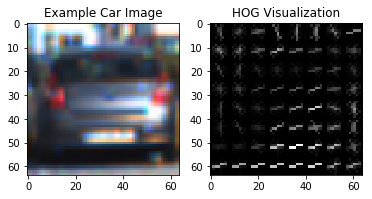

In [4]:
# Generate a random index to look at a car image
ind = np.random.randint(0, len(cars))
# Read in the image
image = mpimg.imread(cars[ind])
gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
# Define HOG parameters
orient = 9
pix_per_cell = 8
cell_per_block = 2
# Call our function with vis=True to see an image output
features, hog_image = get_hog_features(gray, orient, 
                        pix_per_cell, cell_per_block, 
                        vis=True, feature_vec=False)


# Plot the examples
fig = plt.figure()
plt.subplot(121)
plt.imshow(image, cmap='gray')
plt.title('Example Car Image')
plt.subplot(122)
plt.imshow(hog_image, cmap='gray')
plt.title('HOG Visualization')


## Feature Extraction and Training Classifier

Here we define functions for features extraction (HOG, binned color and color histogram features). The functions are based on code from the Udacity's lectures.

The following code chunk creates feature list for the training data. Feature list is normolized by the `StandardScaler()` method from `sklearn`. The data is splitted into training and testing subsets (80% and 20%).


The classifier (Linear SVM) is trained there as well. 

In [5]:
#-------------------------------------------------------------------#
# Model being Trained and Saved as pickle file here
#-------------------------------------------------------------------#

color_space = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = "ALL" # Can be 0, 1, 2, or "ALL"
spatial_size = (32,32) # Spatial binning dimensions
hist_bins = 32    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or offStandardScaler
y_start_stop = [400, 656] # Min and max in y to search in slide_window()
car_features = extract_features(cars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
notcar_features = extract_features(notcars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)

X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))


# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))
# Use a linear SVC

svc = Pipeline([('scaling', StandardScaler()),
                ('classification', LinearSVC(loss='hinge')),
               ])
# svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)

t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()

# Chosen Linear classifier and scaled and trained with extracted features from data. 
# After training model and parameters were saved as follows for further use.

dist_pickle = {}
dist_pickle["color_space"] = color_space
dist_pickle["svc"] = svc
dist_pickle["scaler"] = X_scaler
dist_pickle["orient"] = orient
dist_pickle["pix_per_cell"] = pix_per_cell
dist_pickle["cell_per_block"] = cell_per_block
dist_pickle["spatial_size"] = spatial_size
dist_pickle["hog_channel"] = hog_channel
dist_pickle["hist_bins"] = hist_bins
dist_pickle["spatial_feat"] = spatial_feat
dist_pickle["hist_feat"] = hist_feat
dist_pickle["hog_feat"] = hog_feat

with open("classifier.p", "wb") as f:
    pickle.dump(dist_pickle, f)

Using: 9 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 8460
6.46 Seconds to train SVC...
Test Accuracy of SVC =  0.9907


In [6]:
#-------------------------------------------------------------------#
# Utility Function to visualize images (Called only When required Testing and Checking)
#-------------------------------------------------------------------#
def visualize3Images(img1, img2, img3, tit1, tit2, tit3, cmap1, cmap2, cmap3, isImg=False):
    f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24, 9))
    #f.tight_layout()
    ax1.grid(True)
    if isImg:
        ax1.imshow(img1, cmap=cmap1)
    else:
        ax1.imshow(mpimg.imread(img1), cmap=cmap1)
    ax1.set_title(tit1, fontsize=20)
    ax2.grid(True)
    if isImg:
        ax2.imshow(img2, cmap=cmap2)
    else:
        ax2.imshow(mpimg.imread(img2), cmap=cmap2)
    ax2.set_title(tit2, fontsize=20)
    ax3.grid(True)
    if isImg:
        ax3.imshow(img3, cmap=cmap3)
    else:
        ax3.imshow(mpimg.imread(img3), cmap=cmap3)
    ax3.set_title(tit3, fontsize=20)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
    plt.show()

In [7]:
#-------------------------------------------------------------------#
# Function to processs Images to accomplish Vehicle Detection Task
#-------------------------------------------------------------------#
def process_image(image):
    
    dist_pickle = pickle.load( open("classifier.p", "rb" ) )
    color_space = dist_pickle["color_space"]
    svc = dist_pickle["svc"]
    X_scaler = dist_pickle["scaler"]
    orient = dist_pickle["orient"]
    pix_per_cell = dist_pickle["pix_per_cell"]
    cell_per_block = dist_pickle["cell_per_block"]
    spatial_size = dist_pickle["spatial_size"]
    hist_bins = dist_pickle["hist_bins"]
    y_start_stop1 = [400, 640] # Min and max in y to search in slide_window()
    y_start_stop2 = [400, 640] # Min and max in y to search in slide_window()
    y_start_stop3 = [400, 640] # Min and max in y to search in slide_window()
    y_start_stop4 = [400, 640] # Min and max in y to search in slide_window()

    xy_window1=(80, 80) # window size to use in slide window function 
    xy_window2=(96, 96) # window size to use in slide window function 
    xy_window3=(128, 128) # window size to use in slide window function 
    xy_window4=(160, 160) # window size to use in slide window function 

    xy_overlap=(0.50, 0.50)# window overlap in slide window function
    draw_image = np.copy(image)
    # Uncomment the following line if you extracted training
    # data from .png images (scaled 0 to 1 by mpimg) and the
    # image you are searching is a .jpg (scaled 0 to 255)
    image = image.astype(np.float32)/255
    global windows
    if windows is None:
        print('inside windows loop')
        windows = slide_window(image, x_start_stop=[None, None], y_start_stop=y_start_stop1, 
                            xy_window=xy_window1, xy_overlap=xy_overlap)
        #temp_img1 = draw_boxes(np.copy(draw_image), windows, color=(255, 0, 0), thick=4)
        #print('I-windows to search', len(windows))
        windows += slide_window(image, x_start_stop=[None, None], y_start_stop=y_start_stop2, 
                            xy_window=xy_window2, xy_overlap=xy_overlap)
        #temp_img2 = draw_boxes(np.copy(draw_image), windows, color=(0, 255, 0), thick=4)
        #print('II-windows to search', len(windows))
        windows += slide_window(image, x_start_stop=[None, None], y_start_stop=y_start_stop3, 
                            xy_window=xy_window3, xy_overlap=xy_overlap)
        #temp_img3 = draw_boxes(np.copy(draw_image), windows, color=(0, 0, 255), thick=4)
        #print('total windows to search', len(windows))
    
    #print('windows size', len(windows))
    hot_windows = search_windows(image, windows, svc, X_scaler, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)                       

    #print('hot_windows', hot_windows)
    window_img = draw_boxes(np.copy(draw_image), hot_windows, color=(0, 255, 0), thick=5)
    heat = np.zeros_like(image[:,:,0]).astype(np.float)  
    
    # Add heat to each box in box list
    heat = add_heat(heat,hot_windows)
    
    # Apply threshold to help remove false positives
    heat = apply_threshold(heat,1)

    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)

    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    final_img = draw_labeled_bboxes(np.copy(draw_image), labels)
    
    # visualize3Images(draw_image, window_img, image_det, 
    #                 'Original', 'Raw Detection', 'Average Box', 
    #                 None, None, None, True)
    
    
    #return labels, final_img
    return  final_img 



In [8]:
#-------------------------------------------------------------------#
# Function to process given test images
#-------------------------------------------------------------------#
def process_test_images():
    TEST_IMAGES_PATH = './test_images'
    TEST_FILE_NAME = "test5.jpg"
    OUTPUT_PATH = './output_images'

    images = []
    for i in range(0, 6):
        images.append(cv2.imread(TEST_IMAGES_PATH + '/test{}.jpg'.format(i+1)))

    # Plot the original image next to the iage showing the detected lane line
    fig, axis = plt.subplots(len(images), 2)
    for row in range(len(images)):
        image_org = images[row]
        axis[row, 0].imshow(cv2.cvtColor(image_org, cv2.COLOR_BGR2RGB))
        axis[row, 0].axis('off')

        # Detect the lane line
        image_det = process_image(image_org)
        
        cv2.imwrite(OUTPUT_PATH + '/test{}_output.jpg'.format(row+1), image_det)

        axis[row, 1].imshow(cv2.cvtColor(image_det, cv2.COLOR_BGR2RGB))
        axis[row, 1].axis('off')

    plt.show()   

### Classifier test

Here we test the calssifier on the test images

inside windows loop


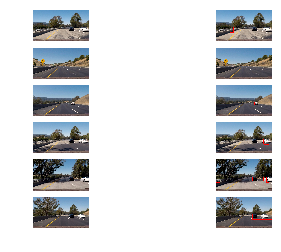

In [9]:
process_test_images()

In [10]:
#-------------------------------------------------------------------#
# Function to process video
#-------------------------------------------------------------------#
def process_video(video_name):
    video_input = VideoFileClip(video_name + ".mp4")
    video_output = video_name + "_output.mp4"
    output = video_input.fl_image(process_image)
    output.write_videofile(video_output, audio=False)

## Video processing

Here we process all three task videos of the project.


In [11]:
process_video('project_video')

/home/hari/anaconda3/lib/python3.6/site-packages/moviepy/audio/io/readers.py:110: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  self.nchannels))



MoviePy: building video file project_video_output.mp4
----------------------------------------

Writing video into project_video_output.mp4
Done writing video in project_video_output.mp4 !                         
Your video is ready !
